In [3]:
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

from imblearn.datasets import fetch_datasets

from imblearn.over_sampling import (
    RandomOverSampler,
    SMOTE,
    ADASYN,
    BorderlineSMOTE,
    SVMSMOTE,
)

In [4]:
oversampler_dict = {

    'random': RandomOverSampler(
        sampling_strategy='auto',
        random_state=0),

    'smote': SMOTE(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        k_neighbors=5,
        n_jobs=4),

    'adasyn': ADASYN(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        n_neighbors=5,
        n_jobs=4),

    'border1': BorderlineSMOTE(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        k_neighbors=5,
        m_neighbors=10,
        kind='borderline-1',
        n_jobs=4),

    'border2': BorderlineSMOTE(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        k_neighbors=5,
        m_neighbors=10,
        kind='borderline-2',
        n_jobs=4),

    'svm': SVMSMOTE(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        k_neighbors=5,
        m_neighbors=10,
        n_jobs=4,
        svm_estimator=SVC(kernel='linear')),
}

In [5]:
# function to train random forests and evaluate the performance

def run_randomForests(X_train, X_test, y_train, y_test):

    rf = RandomForestClassifier(
        n_estimators=100, random_state=39, max_depth=3, n_jobs=4)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print(
        'Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

    print('Test set')
    pred = rf.predict_proba(X_test)
    print(
        'Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))

    return roc_auc_score(y_test, pred[:, 1])

In [7]:
datasets_ls = pd.read_excel("dados2.xlsx")
df = datasets_ls

In [9]:
results_dict = {}
shapes_dict = {}

for dataset_label, dataset in {"df1":df}.items():
    
    results_dict[dataset_label] = {}
    shapes_dict[dataset_label] = {}
    
    X = dataset.drop(['Flag_apo_anul', 'NIF'], axis=1)
    y = dataset['Flag_apo_anul']


    X_train, X_test, y_train, y_test = train_test_split(
    X,  # drop the target
    y,  # just the target
    test_size=0.3,
    random_state=0)
    
    # as many undersampling techniques use KNN
    # we set variables in the same scale
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
        
    roc = run_randomForests(X_train, X_test, y_train, y_test)
    
    # store results
    results_dict[dataset_label]['full_data'] = roc
    shapes_dict[dataset_label]['full_data'] = len(X_train)
    
    print()
    
    for oversampler in oversampler_dict.keys():
        
        print(oversampler)
        
        # resample
        X_resampled, y_resampled = oversampler_dict[oversampler].fit_resample(X_train, y_train)
        
        # evaluate performance
        roc = run_randomForests(X_resampled, X_test, y_resampled, y_test)
        
        #store results
        results_dict[dataset_label][oversampler] = roc
        shapes_dict[dataset_label][oversampler] = len(X_resampled)
        print()
        
    print()
        

Train set
Random Forests roc-auc: 0.9221326836581708
Test set
Random Forests roc-auc: 0.7619047619047619

random
Train set
Random Forests roc-auc: 0.9120735734081985
Test set
Random Forests roc-auc: 0.7494331065759636

smote
Train set
Random Forests roc-auc: 0.9485961666842742
Test set
Random Forests roc-auc: 0.7840136054421768

adasyn
Train set
Random Forests roc-auc: 0.9501185036224402
Test set
Random Forests roc-auc: 0.764172335600907

border1
Train set
Random Forests roc-auc: 0.9451222664529804
Test set
Random Forests roc-auc: 0.7465986394557823

border2
Train set
Random Forests roc-auc: 0.9406794350572463
Test set
Random Forests roc-auc: 0.7426303854875284

svm
Train set
Random Forests roc-auc: 0.9455290602873746
Test set
Random Forests roc-auc: 0.7358276643990929




In [10]:
#Compare the full-Dataset (without under-sampling) with the different methods of under-sampling

lb = pd.Series(results_dict[dataset_label]).sort_values(ascending=False)
lb

smote        0.784014
adasyn       0.764172
full_data    0.761905
random       0.749433
border1      0.746599
border2      0.742630
svm          0.735828
dtype: float64

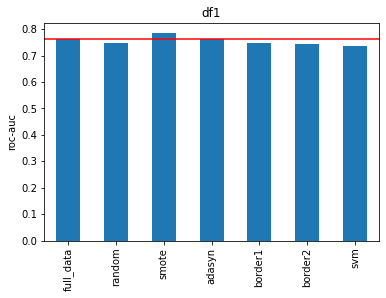

In [11]:
#Compare with a barplot the full-Dataset (without under-sampling) with the different methods of under-sampling

pd.Series(results_dict[dataset_label]).plot.bar()
plt.title(dataset_label)
plt.ylabel('roc-auc')
plt.axhline(results_dict[dataset_label]['full_data'], color='r')
plt.show()